# **Welcome to our project report! ✨🧪**

## 🌎 *Introduction*

The pKaPredict package is a cheminformatics tool designed to estimate the acid dissociation constant (pKa) of chemical compounds based on their molecular structure. The [pKa](https://chemistrytalk.org/what-is-pka/) value is a fundamental physicochemical property that indicates the strength of an acid in an aqueous solution. Specifically, it represents the pH at which a molecule exists in equilibrium between its protonated and deprotonated forms. It is defined as the negative logarithm (base 10) of a compound’s acid dissociation constant in water (Ka). Accurate knowledge of pKa is critical in [fields](https://www.pion-inc.com/blog/what-is-pka-and-how-is-it-used-in-drug-development) such as drug development, environmental chemistry, and molecular biology, where ionization affects solubility, permeability, binding affinity, and reactivity. <br>

*pKaPredict* leverages computational chemistry and machine learning to deliver fast and reproducible predictions of pKa values. The pipeline begins by converting SMILES (Simplified Molecular Input Line Entry System) strings into molecular descriptors using the RDKit cheminformatics library. These descriptors encode key structural and electronic features of molecules and serve as input variables for the predictive model. <br>

The descriptor generation process is handled by the **smiles_to_rdkit_descriptors** function, which transforms SMILES strings into a comprehensive set of numerical descriptors. These include 2D physicochemical properties, topological indices, and fragment-based counts. <br>

In the next stage, the pre-trained regression model is loaded using the load_model function, and pKa predictions are generated through the **predict_pKa** function. The model was trained on a dataset containing molecules with experimentally determined pKa values ranging approximately from 2 to 12. These molecules were first converted into molecular descriptors via the **RDKit_descriptors** function. Among the models tested from the LazyPredict library, the LGBMRegressor yielded the best performance and was selected as the final model. <br>

Prior to model training, the dataset was cleaned by removing duplicates and missing values using the **clean_and_visualize_pka** function. Moreover, supplementary tools such as the plot_data enable the visualization of predicted versus experimental values and generate graphical summaries to support model evaluation and interpretation. <br>

The central component of the package is the **predict_pKa** function, which integrates the aforementioned steps into a streamlined workflow, enabling users to perform end-to-end pKa predictions from molecular input to final output.


## 🚀 *Overview*
🤯 Acquiring Dataset <br>
🧹 Cleaning Dataset <br>
🛟 Saving the cleaned data to a csv file <br>
🤓 Computation of RDKit Molecular Descriptors <br>
💡 Formatting the dataset for machine learning <br>
🕹️ Machine learning model selection <br>
🌲 Machine learning model 🥇: ExtraTreesRegressor <br>
🤖 Machine learning model 🥈 : LGBMRegressor <br>
🧐 Comparison of the two machine learning models <br>
🧅 Saving the LGBMRegressor trained model <br>
🩷 Results: usage of this trained machine learning model <br>
💬 Discussion



**Import statements**:

In [9]:
# Standard library
import os
import time
import pickle
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn  # Included both in case both are used differently
import matplotlib.patches as mpatches

# Web and display
import requests
import IPython.display as ipd

# Chemistry
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# LightGBM
from lightgbm import LGBMRegressor

# LazyPredict
from lazypredict.Supervised import LazyRegressor

# Statistics
from scipy import stats

# Progress bar
from tqdm import tqdm


## 🤯 *Acquiring Dataset*
In a first step, the training [pKa dataset](https://github.com/cbio3lab/pKa/blob/main/Data/test_acids_bases_descfinal_nozwitterions.csv) is acquired from cbio3lab's repository, initially extracted from the Harvard [dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6A67L9). 


1) Download of the data directly into the working directory:

In [10]:


# Raw file URL
url = "https://raw.githubusercontent.com/anastasiafloris/pKaPredict/main/data/pkadatasetRAWDATA.csv"

# Get the repository root by going up one level from the current working directory
repo_root = Path.cwd().parent  # Moves one level up from "notebooks" 

# Define the correct save directory inside the repo's "data" folder
save_dir = repo_root / "data"
save_dir.mkdir(parents=True, exist_ok=True)  # Ensure the "data" folder exists

# Define the full file path
file_path = save_dir / "pkadatasetRAWDATA.csv"

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request fails

    # Check if the content is an HTML page (meaning it's the wrong link)
    if "<!DOCTYPE html>" in response.text:
        print("❌ Error: This is an HTML page, not the CSV file. Check your URL.")
    else:
        with open(file_path, "wb") as file:  # Save inside "data" folder of the repo
            file.write(response.content)
        print(f"✅ File downloaded successfully: {file_path}")

except requests.exceptions.RequestException as e:
    print(f"❌ Failed to download file: {e}")


✅ File downloaded successfully: /Users/anastasiafloris/Desktop/pKaPredict/pKaPredict/data/pkadatasetRAWDATA.csv


2) Opening of the file and verification of its existence as well as display a preview of the latter:

In [11]:

# Define the current working directory
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

# Specify the path to the dataset file (as a string)
file_path = os.path.join("..", "data", "pkadatasetRAWDATA.csv")

# Convert file_path (string) to a Path object before checking existence
file_path_obj = Path(file_path)

# Verify the file's existence and read its contents if available
if file_path_obj.exists():  # ✅ Use the Path object to check existence
    print("The dataset file exists. Reading the file contents...\n")
    
    # Open and display the contents 
    with file_path_obj.open("r", encoding="utf-8") as file:  # ✅ Use Path object to open
        content = file.read()
        print(content[:100])  # Prints only the first 100 characters for preview
    
    # Load the dataset using pandas
    try:
        data_pka = pd.read_csv(file_path, delimiter=",")  # ✅ Still using the original string path
        print("\n✅ Dataset successfully loaded. Preview:")
        
        # Display interactive scrollable table in VS Code/Jupyter
        from IPython.display import display
        display(data_pka.head(10))  # Display first 10 rows
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")

else:
    print("❌ Error: The specified file does not exist.")




Current Directory: /Users/anastasiafloris/Desktop/pKaPredict/pKaPredict/notebooks
The dataset file exists. Reading the file contents...

Compound,set,Smiles,pka,prot_smiles,deprot_smiles,acid_base_type,acid_base_string,prot_charge,deprot

✅ Dataset successfully loaded. Preview:


,Compound,set,Smiles,pka,prot_smiles,deprot_smiles,acid_base_type,acid_base_string,prot_charge,deprot_charge,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,4,test,Brc1ccc(-c2nn[nH]n2)cc1,3.73,Brc1ccc(-c2nn[nH]n2)cc1,Brc1ccc(-c2nn[n-]n2)cc1,acidic,A,0,-1,...,16.98,0.09,-0.05,0.01,0.01,0.00,1,3,7.42,23.10
1,6,test,Brc1ccc(C2NCCS2)cc1,5.05,Brc1ccc(C2NCCS2)cc1,Brc1ccc(C2[NH2+]CCS2)cc1,basic,B,1,0,...,19.32,0.11,-0.07,0.02,0.01,0.00,1,1,15.16,29.56
2,7,test,Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1,7.00,Brc1ccc(Cc2c3ccccc3[nH+]c3ccccc23)cc1,Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1,basic,B,1,0,...,37.15,0.09,-0.04,-0.01,0.02,-0.01,0,1,17.91,48.69
3,18,test,Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1,11.30,Brc1cccc(Br)c1N(C1=[NH+]CCN1)C1CCCCC1,Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1,basic,B,1,0,...,111.84,0.24,-0.17,0.10,-0.04,-0.07,1,3,27.31,48.47
4,21,test,Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1,10.90,Brc1cccc(Br)c1N(CC1CCCC1)C1=[NH+]CCN1,Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1,basic,B,1,0,...,108.67,0.24,-0.18,0.11,-0.05,-0.07,1,3,27.31,48.47
5,29,test,Brc1ccccc1-c1nn[nH]n1,3.83,Brc1ccccc1-c1nn[nH]n1,Brc1ccccc1-c1nn[n-]n1,acidic,A,0,-1,...,32.50,0.09,-0.04,0.01,-0.04,0.02,1,3,7.42,23.10
6,35,test,Brc1cncc2ccccc12,3.54,Brc1c[nH+]cc2ccccc12,Brc1cncc2ccccc12,basic,B,1,0,...,26.29,0.10,-0.05,-0.02,0.03,-0.01,0,1,9.17,23.99
7,41,test,C#CC(C)(C)N(C)C(C)(C)C#C,6.65,C#CC(C)(C)N(C)C(C)(C)C#C,C#CC(C)(C)[NH+](C)C(C)(C)C#C,basic,B,1,0,...,13.00,0.11,-0.07,0.02,0.00,-0.00,0,1,20.56,31.80
8,52,test,C#CCCCC(=O)O,4.60,C#CCCCC(=O)O,C#CCCCC(=O)[O-],acidic,A,0,-1,...,4.66,0.20,-0.09,0.01,0.00,-0.06,1,2,9.70,17.50
9,62,test,C#CCCN,9.23,C#CCC[NH3+],C#CCCN,basic,B,1,0,...,1.17,0.05,-0.01,-0.02,0.01,0.00,1,1,6.99,12.81


## 🧹 *Cleaning Dataset*

✅ Prints initial dataset shape <br> 
✅ Counts and removes missing values (NaN) and duplicates <br>
✅ Prints final dataset shape after cleaning  <br>
✅ Generates a histogram to visualize pKa value distribution  <br>

In [12]:

from pkapredict.clean_and_visualize_pka import clean_and_visualize_pka
# Load the dataset
file_path = os.path.join("..", "data", "pkadatasetRAWDATA.csv")

try:
    data_pka = pd.read_csv(file_path, sep=None, engine="python")  # Auto-detect delimiter
    print("✅ Dataset successfully loaded.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    data_pka = None
clean_and_visualize_pka(data_pka)

   

✅ Dataset successfully loaded.

🔹 Checking dataset information:
Initial dataset shape: (1297, 274)

Missing values before cleaning:
pka               0
acid_base_type    0
Smiles            0
dtype: int64

Total duplicate rows removed: 0
Dataset shape after NaN and duplicate removal: (1297, 3)


📊 Presentation of the pKa dataset as a histogram:


📊 Generating histogram for pKa distribution...



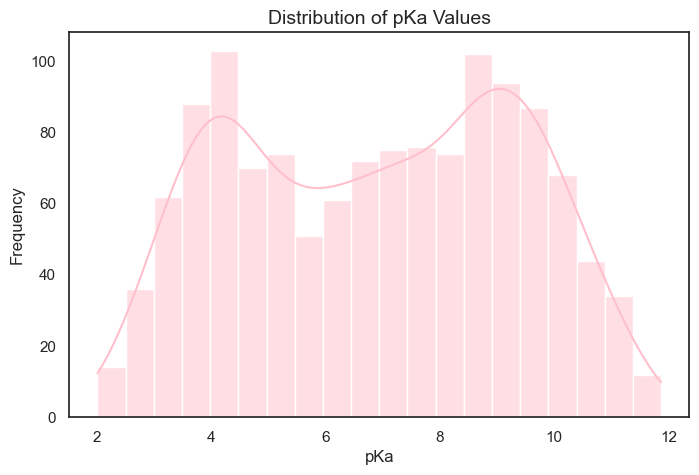

📁 Histogram saved successfully at: ../notebooks/Plots/pKa_distribution_of_the_dataset.png


In [13]:

# Generate histogram for pKa distribution
print("\n📊 Generating histogram for pKa distribution...\n")

# Set white background 
sns.set_theme(style="white")

# Create figure
plt.figure(figsize=(8, 5))
sns.histplot(data=data_pka, x="pka", binwidth=0.5, kde=True, color="pink")  


plt.xlabel("pKa", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of pKa Values", fontsize=14)
plt.grid(False)  

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "pKa_distribution_of_the_dataset.png")

# Save histogram as PNG
plt.savefig(save_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

# Success message
print(f"📁 Histogram saved successfully at: {save_path}")





## 🛟 *Saving the cleaned data to a CSV file*

In [14]:

cleaned_data = clean_and_visualize_pka(data_pka)

if cleaned_data is not None:
    save_path = os.path.join("..", "data", "pKadata_cleaned.csv")
    cleaned_data.to_csv(save_path, index=False)
    print(f"✅ Cleaned dataset successfully saved at: {save_path}")



🔹 Checking dataset information:
Initial dataset shape: (1297, 274)

Missing values before cleaning:
pka               0
acid_base_type    0
Smiles            0
dtype: int64

Total duplicate rows removed: 0
Dataset shape after NaN and duplicate removal: (1297, 3)


## 🤓 *Computation of RDKit Molecular Descriptors*
Molecular descriptors are essential for pKa prediction using machine learning because they provide numerical representations of molecular structures, enabling the model to identify patterns and correlations between molecular features and pKa values.

In [15]:

from pkapredict.RDkit_descriptors import RDkit_descriptors

# Load cleaned data containing SMILES
file_path_cleaned = os.path.join("..", "data", "pKadata_cleaned.csv")
cleaned_data = pd.read_csv(file_path_cleaned)

# Compute descriptors
Mol_descriptors, desc_names = RDkit_descriptors(cleaned_data['Smiles'])

# Create DataFrame with descriptors and add SMILES column
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.insert(0, "Smiles", cleaned_data['Smiles'])  # Insert Smiles as the first column

# Save descriptors as CSV file in pkapredict/data
save_path = os.path.join("..", "data", "Data_pKa_Descriptors.csv")
df_descriptors.to_csv(save_path, index=False)

print("Descriptor computation completed.")
print(f"Training data descriptors saved as '{save_path}'.")


Computing Molecular Descriptors: 100%|██████████| 1297/1297 [00:37<00:00, 34.35it/s]


Descriptor computation completed.
Training data descriptors saved as '../data/Data_pKa_Descriptors.csv'.


## 💡 *Formatting the dataset for machine learning*
This section of the code prepares the dataset for training a machine learning model by splitting it into training and validation sets and standardizing the features.

In [16]:

# Define file paths
file_path1 = os.path.join("..", "data", "Data_pKa_Descriptors.csv")  # Descriptors (X)
file_path2 = os.path.join("..", "data", "pKadata_cleaned.csv")  # pKa values (y)

# Load the datasets
df_descriptors = pd.read_csv(file_path1)  # Features (X)
df_pKa = pd.read_csv(file_path2)  # Target values (y)

# Display first few rows of both datasets
print("Descriptors DataFrame:\n", df_descriptors.head())
print("pKa DataFrame:\n", df_pKa.head())

# Ensure the 'Smiles' column is present in both
common_column = 'Smiles'

# Merge descriptors with pKa values using 'Smiles'
df_merged = df_descriptors.merge(df_pKa[['pka', common_column]], on=common_column)

# Drop non-numeric columns (Smiles)
X = df_merged.drop(columns=['pka', 'Smiles'])  # Drop pKa (target) and Smiles (string)
y = df_merged['pka']  # Target variable (pKa values)

# Verify all columns are numeric
print("X columns before standardization:", X.dtypes)

# Split data into training (90%) and validation (10%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Print shape to confirm data processing
print(f"Training set shape: {X_train.shape}, Validation set shape: {X_valid.shape}")

# Success message 🎀
print("The training and validation sets have been successfully created 🎀")


Descriptors DataFrame:
                               Smiles  MaxAbsEStateIndex  MaxEStateIndex  \
0            Brc1ccc(-c2nn[nH]n2)cc1               7.72            7.72   
1                Brc1ccc(C2NCCS2)cc1               8.28            8.28   
2  Brc1ccc(Cc2c3ccccc3nc3ccccc23)cc1               9.01            9.01   
3  Brc1cccc(Br)c1N(C1=NCCN1)C1CCCCC1               9.19            9.19   
4  Brc1cccc(Br)c1N(CC1CCCC1)C1=NCCN1               8.93            8.93   

   MinAbsEStateIndex  MinEStateIndex  qed   SPS  MolWt  HeavyAtomMolWt  \
0               0.07           -0.27 0.80 15.92 225.05          220.01   
1               0.04           -2.84 0.81 51.08 244.16          234.08   
2               0.22           -3.03 0.42 20.77 348.24          334.13   
3               0.06           -4.12 0.80 53.20 401.15          381.99   
4               0.05           -4.13 0.82 50.80 401.15          381.99   

   ExactMolWt  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0

## 🕹️ *Machine learning model selection*

 98%|█████████▊| 41/42 [00:52<00:01,  1.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19271
[LightGBM] [Info] Number of data points in the train set: 1167, number of used features: 176
[LightGBM] [Info] Start training from score 6.913366


100%|██████████| 42/42 [00:53<00:00,  1.27s/it]


📁 Figure saved successfully at: ../notebooks/Plots/Top10MLModels.png


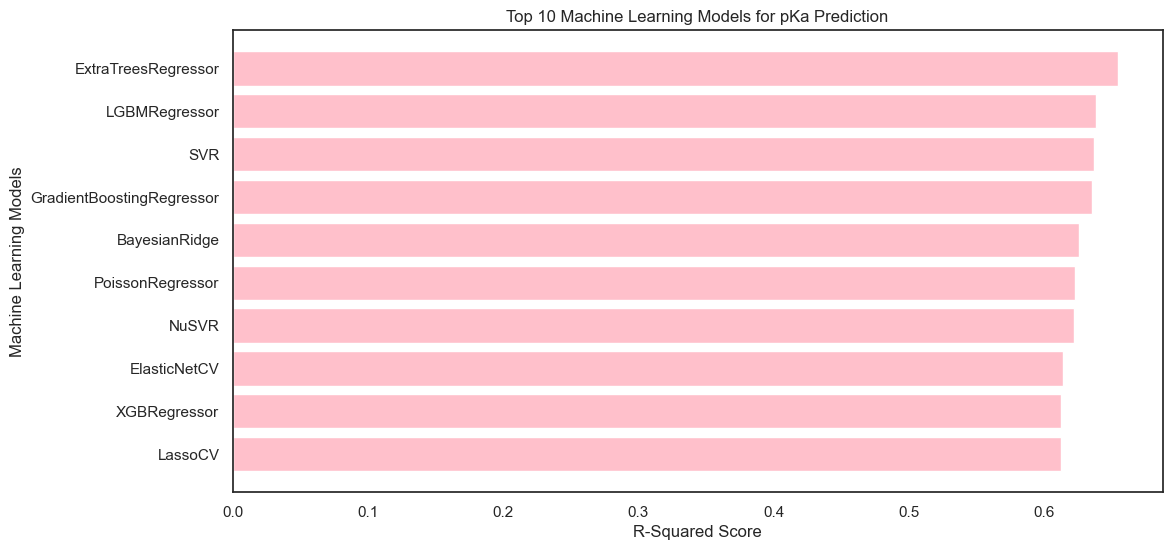

Model selection completed! 🎯 The best-performing models have been visualized and saved as 'Top10MLModels.png'.


In [17]:


# =============================
# Run LazyRegressor 
# =============================

# Initialize LazyRegressor
lregs = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, random_state=42)

# Fit models on the pKa dataset
models, prediction_tests = lregs.fit(X_train_scaled, X_valid_scaled, y_train, y_valid)

# =============================
# Visualize Top Models
# =============================

# Sort models by R-squared score (best performing first)
models_sorted = models.sort_values(by="R-Squared", ascending=False)

# Plot top 10 models
plt.figure(figsize=(12, 6))
plt.barh(models_sorted.index[:10], models_sorted["R-Squared"][:10], align='center', color='pink')
plt.xlabel("R-Squared Score")
plt.ylabel("Machine Learning Models")
plt.title("Top 10 Machine Learning Models for pKa Prediction")
plt.gca().invert_yaxis()  # Best model on top


# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "Top10MLModels.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print(f"📁 Figure saved successfully at: {save_path}")



# Show plot
plt.show()

print("Model selection completed! 🎯 The best-performing models have been visualized and saved as 'Top10MLModels.png'.")


## 🌲 *Machine learning model 🥇 : ExtraTreesRegressor*

In [18]:


# =============================
# 1st Grid Search for ExtraTreesRegressor
# =============================

# Define initial hyperparameter grid
params = {
    "max_depth": list(range(15, 26, 5)),  # Trying depths between 10 and 30
    "n_estimators": list(range(100, 500, 100)),  # Number of trees between 100 and 500
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=params,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Print best hyperparameters
print("Optimized parameters for ExtraTreesRegressor:", grid_search.best_params_)

# =============================
# 2nd Grid Search for Further Optimization
# =============================

# Extract best hyperparameters from first search
best_params = grid_search.best_params_

# Define refined hyperparameter grid
params_bst = {
    "max_depth": list(range(best_params["max_depth"] - 2, best_params["max_depth"] + 3, 1)),
    "n_estimators": list(range(best_params["n_estimators"] - 50, best_params["n_estimators"] + 100, 50)),
    "min_samples_split": [best_params["min_samples_split"] - 1, best_params["min_samples_split"], best_params["min_samples_split"] + 1],
}

# Initialize refined GridSearchCV
grid_search_bst = GridSearchCV(
    ExtraTreesRegressor(random_state=42),
    param_grid=params_bst,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search_bst.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("The best parameters after further optimization:", grid_search_bst.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


Optimized parameters for ExtraTreesRegressor: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 400}
Fitting 3 folds for each of 45 candidates, totalling 135 fits
The best parameters after further optimization: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 400}


The hyperparameter tuning for ExtraTreesRegressor was conducted in two stages to identify the optimal parameters for predicting pKa values efficiently. In the first grid search, 36 different hyperparameter combinations were tested using 3-fold cross-validation (cv=3) instead of 5-fold to significantly reduce computational time while maintaining accuracy. This resulted in an initial best model with max_depth = 25, min_samples_split = 2, and n_estimators = 100. To further refine the model, a second grid search was conducted, focusing on a narrower range of max_depth (15 to 26 instead of 10 to 31) and adjusting n_estimators, leading to the final optimized values: max_depth = 23, min_samples_split = 2, and n_estimators = 150. These refinements balanced model complexity and efficiency, ensuring improved generalization while significantly reducing training time. 🚀

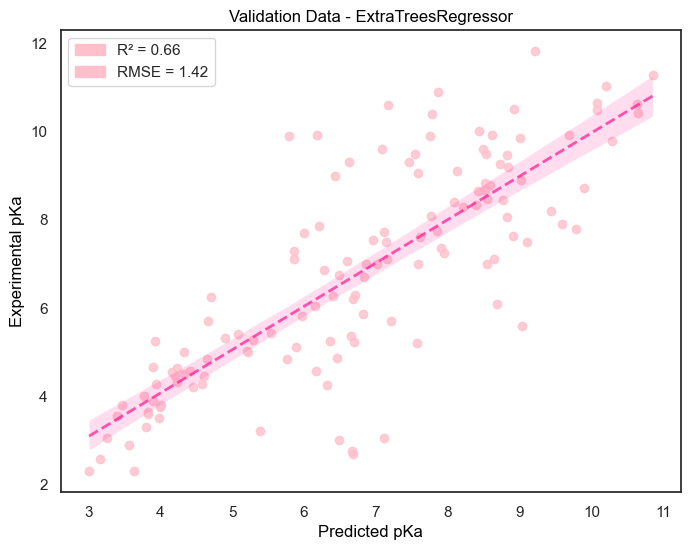

✅ Plot generated with R² = 0.66 and RMSE = 1.42
Plot saved as validation_ExtraTrees.png


<Figure size 640x480 with 0 Axes>

In [19]:


# =============================
# Train ExtraTreesRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 150}

# Initialize the model with optimized parameters
model = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_preds = model.predict(X_valid_scaled)

# =============================
# Define Function for Plotting
# =============================

from pkapredict.plot_data import plot_data

# =============================
# Plot and Save Results
# =============================

# Plot validation results
plot_data(y_valid, y_preds, "Validation Data - ExtraTreesRegressor")

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validation_ExtraTrees.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print("Plot saved as validation_ExtraTrees.png")

📶 Optimization of a supplementary parameter of this model through the selection of the most relavent descriptors to pKa prediction using SelectKBest. The following code plots all R² values as a function of k values and prints the optimal one.

Optimal k: 95 with Highest R²: 0.6738
Plot saved as optimalkvalue.png


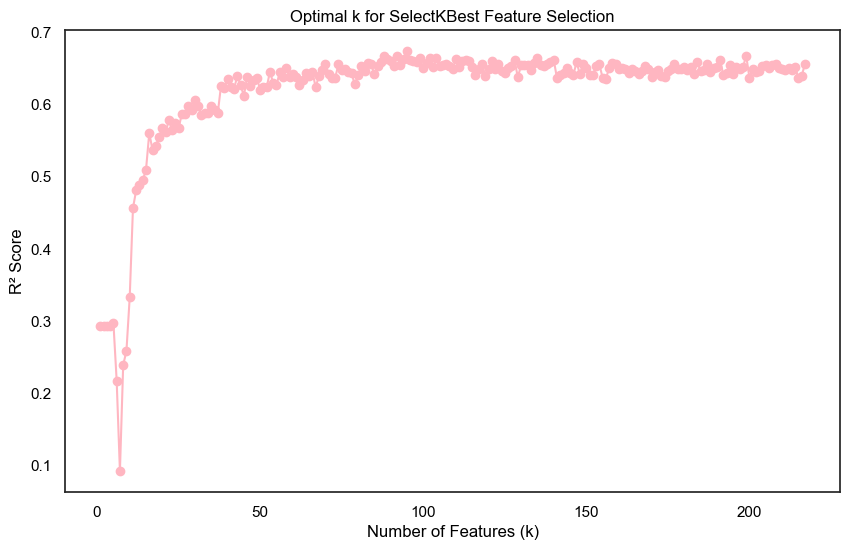

In [20]:


# Define range of k values (from 1 to total number of features, step 1)
k_values = list(range(1, X_train_scaled.shape[1] + 1))

# Store R² scores for each k
r2_scores = []

# Loop through k values and train ExtraTreesRegressor
for k in k_values:
    # Select top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_valid_selected = selector.transform(X_valid_scaled)

    # Train ExtraTreesRegressor with selected features
    model = ExtraTreesRegressor(n_estimators=150, max_depth=23, min_samples_split=2, random_state=42)
    model.fit(X_train_selected, y_train)

    # Make predictions
    y_preds = model.predict(X_valid_selected)

    # Compute R² score
    r2 = r2_score(y_valid, y_preds)
    r2_scores.append(r2)

# Find the optimal k value
optimal_k = k_values[np.argmax(r2_scores)]
best_r2 = max(r2_scores)

# Print optimal k value with highest R²
print(f"Optimal k: {optimal_k} with Highest R²: {best_r2:.4f}")

# Plot R² Scores vs. k Values
plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='lightpink')
plt.xlabel("Number of Features (k)", color="black")
plt.ylabel("R² Score", color="black")
plt.title("Optimal k for SelectKBest Feature Selection", color="black")
plt.gca().set_facecolor('white')  
plt.tick_params(axis='both', colors='black')  

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "optimalkvalue.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')


print("Plot saved as optimalkvalue.png")


💪🏻 Plot of the data with the optimized machine leaning parameters of this model!

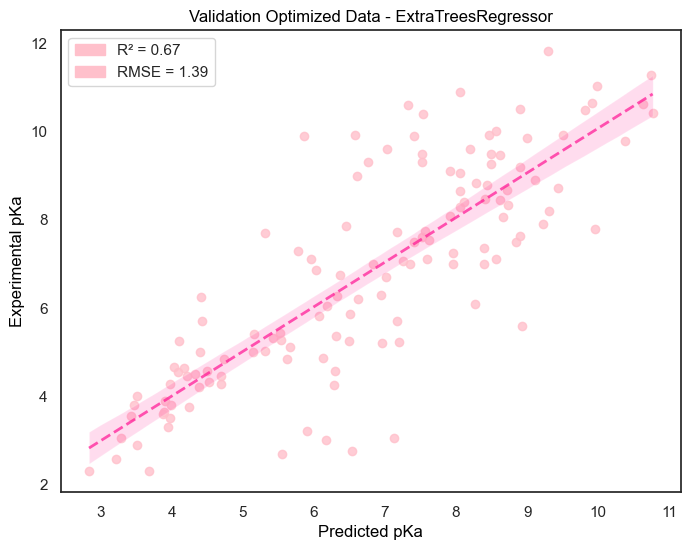

✅ Plot generated with R² = 0.67 and RMSE = 1.39
Plot saved as validationoptimized_ExtraTrees.png


<Figure size 640x480 with 0 Axes>

In [21]:


# =============================
# Feature Selection with SelectKBest (k=95)
# =============================

k = 95  # Number of best features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_valid_selected = selector.transform(X_valid_scaled)

# =============================
# Train ExtraTreesRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 150}

# Initialize the model with optimized parameters
model = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the validation set
y_preds = model.predict(X_valid_selected)

# =============================
# Define Function for Plotting
# =============================

from pkapredict.plot_data import plot_data

# =============================
# Plot and Save Results
# =============================

# Plot validation results
plot_data(y_valid, y_preds, "Validation Optimized Data - ExtraTreesRegressor")

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validationoptimized_ExtraTrees.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Success message
print("Plot saved as validationoptimized_ExtraTrees.png")






⚡️ Computation of statistics for this model

In [ ]:

# =============================
# Compute Model Performance Metrics
# =============================

# Compute mean error
mean_error = np.mean(y_preds - y_valid)

# Compute variance of the error
variance_error = np.var(y_preds - y_valid)

# Compute mean predicted value
mean_predicted = np.mean(y_preds)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_valid, y_preds)

# Compute R² score
r2 = r2_score(y_valid, y_preds)

# Compute 95% confidence interval for predictions
confidence = 0.95
n = len(y_preds)
std_err = stats.sem(y_preds - y_valid)
margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2., n-1)
confidence_interval = (mean_error - margin_of_error, mean_error + margin_of_error)

# Print computed metrics
print(f"Mean Error: {mean_error:.4f}")
print(f"Variance of Error: {variance_error:.4f}")
print(f"Mean Predicted Value: {mean_predicted:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"95% Confidence Interval: {confidence_interval}")

# Create a DataFrame for storing the results
stats_df = pd.DataFrame({
    "Metric": ["Mean Error", "Variance", "Mean Predicted Value", "MSE", "R²", "95% CI Lower", "95% CI Upper"],
    "Value": [mean_error, variance_error, mean_predicted, mse, r2, confidence_interval[0], confidence_interval[1]]
})


stats_save_path = os.path.join("..", "data", "ExtraTreesRegressor_stats.csv")
stats_df.to_csv(stats_save_path, index=False)
print(f"Table saved at: {stats_save_path}")

# Display as an interactive HTML table
ipd.display(ipd.HTML(stats_df.to_html(classes='table table-striped', escape=False)))




Mean Error: -0.0339
Variance of Error: 1.9210
Mean Predicted Value: 6.7538
MSE: 1.9222
R²: 0.6738
95% Confidence Interval: (np.float64(-0.2753287801671801), np.float64(0.20755466782535487))
Table saved at: ../data/ExtraTreesRegressor_stats.csv


,Metric,Value
0,Mean Error,-0.03
1,Variance,1.92
2,Mean Predicted Value,6.75
3,MSE,1.92
4,R²,0.67
5,95% CI Lower,-0.28
6,95% CI Upper,0.21


## 🤖 *Machine learning model 🥈 : LGBMRegressor*

In [23]:


# =============================
# Load and Prepare Data
# =============================

# Define file paths
file_path1 = os.path.join("..", "data", "Data_pKa_Descriptors.csv")  # Descriptors (X)
file_path2 = os.path.join("..", "data", "pKadata_cleaned.csv")  # pKa values (y)

# Load the datasets
df_descriptors = pd.read_csv(file_path1)  # Features (X)
df_pKa = pd.read_csv(file_path2)  # Target values (y)

# Merge descriptors with pKa values using 'Smiles'
df_merged = df_descriptors.merge(df_pKa[['pka', 'Smiles']], on='Smiles')

# Drop non-numeric columns (Smiles)
X = df_merged.drop(columns=['pka', 'Smiles'])  # Drop pKa (target) and Smiles (string)
y = df_merged['pka']  # Target variable (pKa values)

# Split data into training (90%) and validation (10%) sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Convert back to DataFrame to avoid warnings in prediction
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_valid_scaled_df = pd.DataFrame(X_valid_scaled, columns=X.columns)

# =============================
# 1st Grid Search for LGBMRegressor (Optimized for Speed)
# =============================

# Start timing
start_time = time.time()

# Define initial hyperparameter grid with reduced values for speed
params = {
    "max_depth": [10, 15],  # Smaller range
    "n_estimators": [100, 200],  # Fewer estimators
    "learning_rate": [0.05, 0.1],  # Limited choices
    "num_leaves": [20, 31],  # Small variation
    "min_child_samples": [10, 20]  # Small variation
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LGBMRegressor(random_state=42, verbose=-1),  
    param_grid=params,
    cv=2,  
    verbose=0,  
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled_df, y_train)

# Print best hyperparameters
print("Optimized parameters for LGBMRegressor:", grid_search.best_params_)

# =============================
# 2nd Grid Search for Further Optimization
# =============================

# Extract best hyperparameters from first search
best_params = grid_search.best_params_

# Define refined hyperparameter grid
params_bst = {
    "max_depth": [best_params["max_depth"] - 1, best_params["max_depth"], best_params["max_depth"] + 1],
    "n_estimators": [best_params["n_estimators"] - 50, best_params["n_estimators"] + 50],
    "learning_rate": [best_params["learning_rate"] * 0.9, best_params["learning_rate"], best_params["learning_rate"] * 1.1],
    "num_leaves": [best_params["num_leaves"] - 5, best_params["num_leaves"] + 5],
    "min_child_samples": [best_params["min_child_samples"] - 5, best_params["min_child_samples"] + 5]
}

# Initialize refined GridSearchCV
grid_search_bst = GridSearchCV(
    LGBMRegressor(random_state=42, verbose=-1),  
    param_grid=params_bst,
    cv=2,  
    verbose=0, 
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search_bst.fit(X_train_scaled_df, y_train)

# Print the best hyperparameters
print("The best parameters after further optimization:", grid_search_bst.best_params_)

# End timing
end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

Optimized parameters for LGBMRegressor: {'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 20}
The best parameters after further optimization: {'learning_rate': 0.045000000000000005, 'max_depth': 9, 'min_child_samples': 5, 'n_estimators': 250, 'num_leaves': 15}
Total execution time: 230.49 seconds


🥳 Implementation of the optimized parameters and plotting of the data distribution as well as the associated R² value

<Figure size 640x480 with 0 Axes>

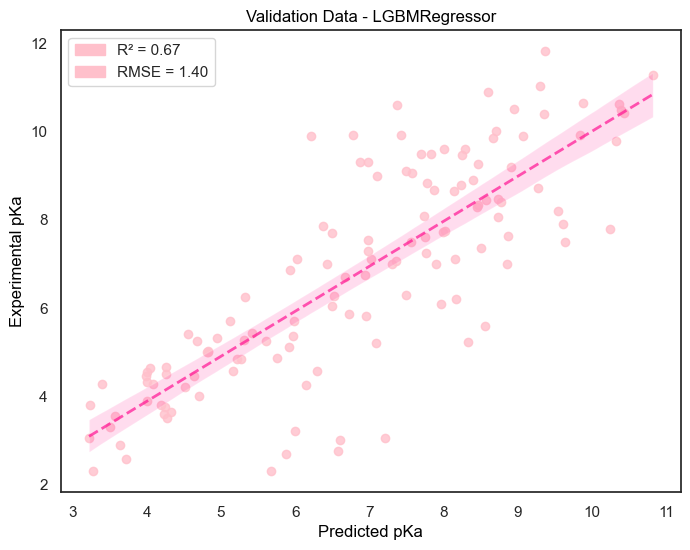

✅ Plot generated with R² = 0.67 and RMSE = 1.40
Plot saved as validation_LGBMRegressor.png


In [24]:


# =============================
# Train LGBMRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {
    'learning_rate': 0.045000000000000005,
    'max_depth': 9,
    'min_child_samples': 5,
    'n_estimators': 250,
    'num_leaves': 15
}

# Initialize the model with optimized parameters
model2 = LGBMRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_samples=best_params['min_child_samples'],
    n_estimators=best_params['n_estimators'],
    num_leaves=best_params['num_leaves'],
    random_state=42,
    verbose=-1  
)

# Train the model
model2.fit(X_train_scaled_df, y_train)

# Make predictions on the validation set
y_preds = model2.predict(X_valid_scaled_df)

# =============================
# Define Function for Plotting
# =============================



# Save figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')
    


# =============================
# Plot and Save Results
# =============================

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validation_LGBMRegressor.png")

# Plot validation results and display the plot
plot_data(y_valid, y_preds, "Validation Data - LGBMRegressor")

# Success message
print("Plot saved as validation_LGBMRegressor.png")



📶 Optimization of a supplementary parameter of this model by selecting the most relavent descriptors to pKa prediction using SelectKBest. The following code plots all R² values as a function of k values and prints the optimal one.

Optimal k: 142 with Highest R²: 0.6803


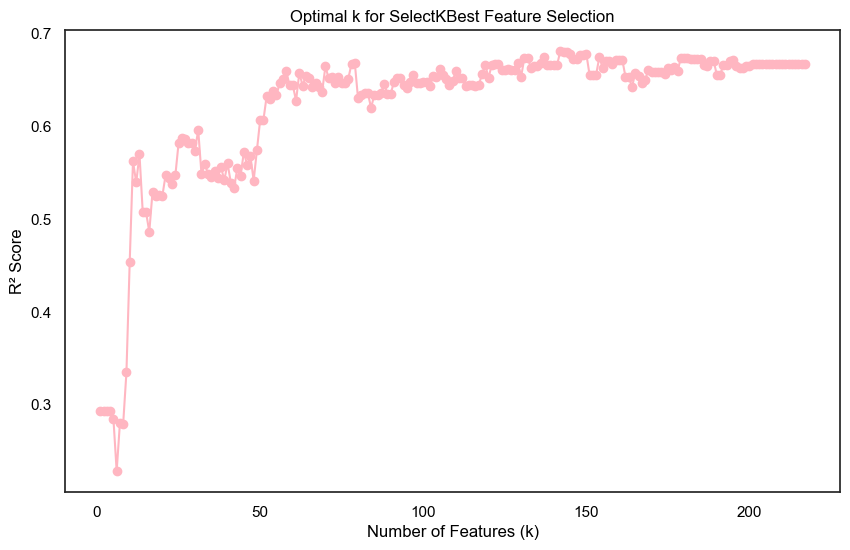

Plot saved as optimalkvalue.png


In [25]:


# Define range of k values (from 1 to total number of features, step 1)
k_values = list(range(1, X_train_scaled_df.shape[1] + 1))

# Store R² scores for each k
r2_scores = []

# Loop through k values and train LGBMRegressor
for k in k_values:
    # Select top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled_df, y_train)
    X_valid_selected = selector.transform(X_valid_scaled_df)

    # Convert selected features back to DataFrame to retain feature names
    selected_features = X_train_scaled_df.columns[selector.get_support()]
    X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
    X_valid_selected_df = pd.DataFrame(X_valid_selected, columns=selected_features)

    # Train LGBMRegressor with selected features
    model2 = LGBMRegressor(
        learning_rate=0.045,
        max_depth=9,
        min_child_samples=5,
        n_estimators=250,
        num_leaves=15,
        random_state=42,
        verbose=-1
    )
    model2.fit(X_train_selected_df, y_train)

    # Make predictions
    y_preds = model2.predict(X_valid_selected_df)

    # Compute R² score
    r2 = r2_score(y_valid, y_preds)
    r2_scores.append(r2)

# Find the optimal k value
optimal_k = k_values[np.argmax(r2_scores)]
best_r2 = max(r2_scores)

# Print optimal k value with highest R²
print(f"Optimal k: {optimal_k} with Highest R²: {best_r2:.4f}")

# Plot R² Scores vs. k Values
plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='lightpink')
plt.xlabel("Number of Features (k)", color="black")
plt.ylabel("R² Score", color="black")
plt.title("Optimal k for SelectKBest Feature Selection", color="black")
plt.gca().set_facecolor('white')  
plt.tick_params(axis='both', colors='black')  

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "optimalkvalue.png")

# Save figure as PNG in the correct directory
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# Success message
print("Plot saved as optimalkvalue.png")


💪🏻 Plotting of the data with the optimized machine leaning parameters of this model!

<Figure size 640x480 with 0 Axes>

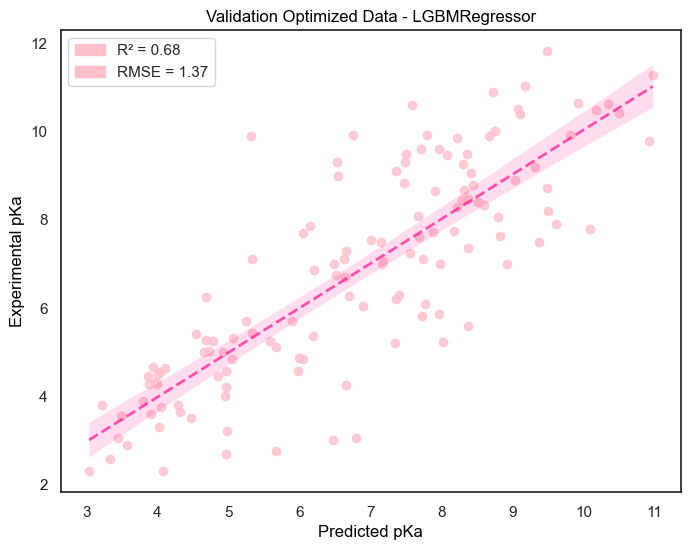

✅ Plot generated with R² = 0.68 and RMSE = 1.37
Plot saved as validationoptimized_LGBMRegressor.png


In [26]:


# =============================
# Feature Selection with SelectKBest (k=142)
# =============================

k = 142  # Optimized number of best features for LGBMRegressor
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled_df, y_train)
X_valid_selected = selector.transform(X_valid_scaled_df)

# Convert selected features back to DataFrame to retain feature names
selected_features = X_train_scaled_df.columns[selector.get_support()]
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_valid_selected_df = pd.DataFrame(X_valid_selected, columns=selected_features)

# =============================
# Train LGBMRegressor with Optimized Parameters
# =============================

# Define the best parameters found from GridSearchCV
best_params = {
    'learning_rate': 0.045,
    'max_depth': 9,
    'min_child_samples': 5,
    'n_estimators': 250,
    'num_leaves': 15
}

# Initialize the model with optimized parameters
model2 = LGBMRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_samples=best_params['min_child_samples'],
    n_estimators=best_params['n_estimators'],
    num_leaves=best_params['num_leaves'],
    random_state=42,
    verbose=-1
)

# Train the model on the selected features
model2.fit(X_train_selected_df, y_train)

# Make predictions on the validation set
y_preds = model2.predict(X_valid_selected_df)

# =============================
# Define Function for Plotting
# =============================



# Save figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')
    


# =============================
# Plot and Save Results
# =============================

# Define save path in the specified folder
save_path = os.path.join("..", "notebooks", "Plots", "validationoptimized_LGBMRegressor.png")

# Plot validation results and display the plot
plot_data(y_valid, y_preds, "Validation Optimized Data - LGBMRegressor")

# Success message
print("Plot saved as validationoptimized_LGBMRegressor.png")


⚡️ Computation of statistics for this model

In [27]:


# Compute mean error
mean_error2 = np.mean(y_preds - y_valid)

# Compute variance of the error
variance_error2 = np.var(y_preds - y_valid)

# Compute mean predicted value
mean_predicted2 = np.mean(y_preds)

# Compute Mean Squared Error (MSE)
mse2 = mean_squared_error(y_valid, y_preds)

# Compute R² score
r2_2 = r2_score(y_valid, y_preds)

# Compute 95% confidence interval for predictions
confidence2 = 0.95
n = len(y_preds)
std_err2 = stats.sem(y_preds - y_valid)
margin_of_error2 = std_err2 * stats.t.ppf((1 + confidence2) / 2., n-1)
confidence_interval2 = (mean_error2 - margin_of_error2, mean_error2 + margin_of_error2)

# Print computed metrics
print(f"Mean Error: {mean_error2:.4f}")
print(f"Variance of Error: {variance_error2:.4f}")
print(f"Mean Predicted Value: {mean_predicted2:.4f}")
print(f"MSE: {mse2:.4f}")
print(f"R²: {r2_2:.4f}")
print(f"95% Confidence Interval: {confidence_interval2}")

# Create a DataFrame for storing the results
stats_df = pd.DataFrame({
    "Metric": ["Mean Error", "Variance", "Mean Predicted Value", "MSE", "R²", "95% CI Lower", "95% CI Upper"],
    "Value": [mean_error2, variance_error2, mean_predicted2, mse2, r2_2, confidence_interval2[0], confidence_interval2[1]]
})


save_path = os.path.join("..", "data","LGBM_regressor_stats.csv")
stats_df.to_csv(save_path, index=False)
print(f"Table saved at: {save_path}")

# Display as an interactive HTML table
ipd.display(ipd.HTML(stats_df.to_html(classes='table table-striped', escape=False)))




Mean Error: -0.0047
Variance of Error: 1.8835
Mean Predicted Value: 6.7829
MSE: 1.8835
R²: 0.6803
95% Confidence Interval: (np.float64(-0.2437992226025819), np.float64(0.23434515460957062))
Table saved at: ../data/LGBM_regressor_stats.csv


,Metric,Value
0,Mean Error,-0.00
1,Variance,1.88
2,Mean Predicted Value,6.78
3,MSE,1.88
4,R²,0.68
5,95% CI Lower,-0.24
6,95% CI Upper,0.23


## 🧐 *Comparison of the two machine learning models*

When evaluating the machine learning models for pKa prediction, R² (coefficient of determination) and RMSE (Root Mean Squared Error) are two key metrics used to assess model performance. R² measures how well the model explains the variance in the experimental pKa values, ranging from 0 (no predictive power) to 1 (perfect prediction). RMSE quantifies the average difference between predicted and actual values, with lower RMSE indicating more accurate predictions.

Initially, ExtraTreesRegressor and LGBMRegressor emerged as the top performers based on their R² scores. However, the final figures demonstrate that both models benefited from hyperparameter tuning and the optimization of k, the number of most relevant descriptors selected using SelectKBest. After optimization, LGBMRegressor achieved the best performance with an R² of 0.68 and an RMSE of 1.37, while ExtraTreesRegressor followed closely with an R² of 0.67 and an RMSE of 1.39. The scatter plots confirm strong correlations between predicted and experimental pKa values, with the optimized models producing more accurate and reliable predictions. 

Figure saved at: ../notebooks/plots/model_comparison_stats.png


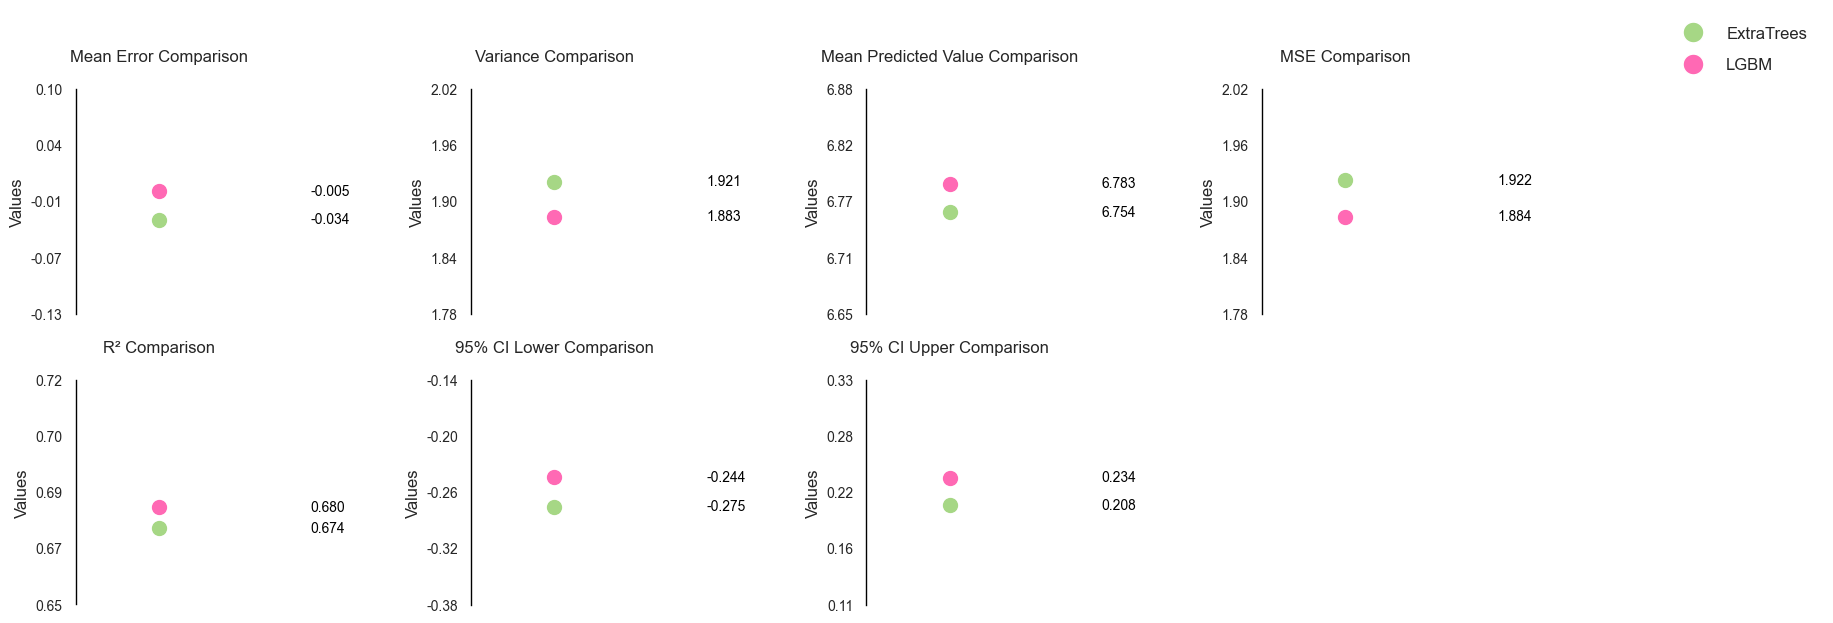

In [28]:


# Define file paths
path1 = os.path.join("..", "data", "ExtraTreesRegressor_stats.csv")
path2 = os.path.join("..", "data", "LGBM_regressor_stats.csv")

# Load data
extra_trees_df = pd.read_csv(path1)
lgbm_df = pd.read_csv(path2)

# Merge data for comparison
comparison_df = extra_trees_df.merge(lgbm_df, on="Metric", suffixes=("_ExtraTrees", "_LGBM"))

# Define metrics and values
metrics = comparison_df["Metric"]
values_extra_trees = comparison_df["Value_ExtraTrees"]
values_lgbm = comparison_df["Value_LGBM"]

# Set up subplot grid (4 columns, 3 rows)
n_cols = 4
n_rows = int(np.ceil(len(metrics) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharey=False, facecolor='white')
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    x_center = 0.5  
    colors = ['#A6D785', '#FF69B4'] 
    labels = ["ExtraTrees", "LGBM"]
    values = [values_extra_trees[i], values_lgbm[i]]
    
    # Set specific y-axis limits for R²
    if metric == "R²":
        y_min, y_max = 0.65, 0.72
    else:
        
        rounded_values = [round(val, 2) for val in values]
        y_min, y_max = min(rounded_values) - 0.1, max(rounded_values) + 0.1
    ax.set_ylim(y_min, y_max)
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.grid(False)  
    
    
    y_ticks = np.linspace(y_min, y_max, num=5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks], fontsize=10)
    
    
    for j, val in enumerate(values):
        ax.scatter(x_center, val, color=colors[j], s=100)
        ax.text(x_center + 0.05, val, f"{val:.3f}", ha='left', va='center', fontsize=10, color='black')
    
    ax.set_xticks([])  
    ax.set_ylabel("Values")  
    ax.set_title(f"{metric} Comparison", pad=20)
    ax.set_facecolor('white')  


legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label="ExtraTrees"),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label="LGBM")]
fig.legend(handles=legend_handles, loc="upper right", bbox_to_anchor=(1.15, 1.05), frameon=False, markerscale=1.5, fontsize=12, 
           handletextpad=1, labelspacing=1, borderpad=1)


for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()


# Define save path
save_path = os.path.join("..", "notebooks", "plots", "model_comparison_stats.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved at: {save_path}")
plt.show()




The comparative analysis between the ExtraTrees and LGBM models reveals distinct performance characteristics across key evaluation metrics.

**Mean Error** : The ExtraTrees model shows a slightly larger absolute error (-0.034) compared to LGBM (-0.005), indicating that LGBM produces predictions that are closer to the expected values on average.

**Variance**: The variance is comparable between both models, with ExtraTrees exhibiting 1.921 and LGBM 1.883, suggesting similar levels of model variability.

**Mean Predicted Value**: Both models yield nearly identical predicted values, with LGBM slightly higher at 6.783 compared to 6.754 for ExtraTrees.

**Mean Squared Error (MSE)**: ExtraTrees has a marginally higher MSE (1.922) compared to LGBM (1.884), suggesting that the LGBM model achieves slightly better prediction accuracy.

**R² Score**: The ExtraTrees model has an R² of 0.674, while LGBM scores 0.680, reinforcing that both models explain the variance in the data quite well, but LGBM performs slightly better in this regard.

**Confidence Intervals**:

The 95% CI lower bound is slightly lower for ExtraTrees (-0.275) than for LGBM (-0.244).
The 95% CI upper bound is 0.208 for ExtraTrees and 0.234 for LGBM, indicating a slightly wider confidence interval for LGBM.
Conclusion
While both models exhibit comparable performance, LGBM slightly outperforms ExtraTrees in most metrics, particularly in terms of lower mean error, higher R², and marginally better MSE. However, the differences are not drastic, and the choice between these models may depend on factors such as computational efficiency and interpretability.

## 🧅 *Saving the LGBMRegressor trained model*

In [29]:


# Ensure the models directory exists
os.makedirs("models", exist_ok=True)

# Save the best model
with open("models/best_pKa_model.pkl", "wb") as file:
    pickle.dump(model2, file)

print("✅ Best model saved as 'models/best_pKa_model.pkl'")


✅ Best model saved as 'models/best_pKa_model.pkl'


## 🩷 *Results: Usage of this trained machine learning model*
As illustrated below, the functionalities provided by the modules of the *pKaPredict* package allow users to input the SMILES string of a target molecule, which is then automatically converted into molecular descriptors. Based on these descriptors, the predicted pKa value is thus computed and displayed.

In [30]:

# Exact descriptor list used during training
descriptor_names = [ 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'SPS', 
    'NumValenceElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 
    'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 
    'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi1', 
    'Chi1n', 'Chi3v', 'Chi4v', 'HallKierAlpha', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 
    'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 
    'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 
    'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 
    'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 
    'SlogP_VSA8', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 
    'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 
    'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState6', 'VSA_EState7', 
    'VSA_EState8', 'VSA_EState9', 'FractionCSP3', 'NHOHCount', 'NOCount', 'NumAliphaticHeterocycles', 
    'NumAliphaticRings', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumBridgeheadAtoms', 
    'NumHAcceptors', 'NumHeteroatoms', 'NumHeterocycles', 'NumRotatableBonds', 'NumSaturatedHeterocycles', 
    'NumSaturatedRings', 'Phi', 'MolMR', 'fr_Al_COO', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_OH', 
    'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 
    'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_alkyl_halide', 
    'fr_allylic_oxid', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_ester', 
    'fr_ether', 'fr_guanido', 'fr_halogen', 'fr_imidazole', 'fr_lactam', 'fr_methoxy', 'fr_nitrile', 
    'fr_nitroso', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_piperdine', 'fr_pyridine', 'fr_quatN', 
    'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_tetrazole', 'fr_thiazole'
]

from pkapredict.load_model import load_model
from pkapredict.smiles_to_rdkit_descriptors import smiles_to_rdkit_descriptors
def main():
    print("🔬 Welcome to the pKa Predictor!")
    smiles = input("👉 Enter a SMILES string (e.g., [NH4+]): ").strip()

    try:
        # Compute descriptors
        descriptors = smiles_to_rdkit_descriptors(smiles, descriptor_names).reshape(1, -1)

        # Create dataframe
        df = pd.DataFrame(descriptors, columns=descriptor_names)

        # Load model and predict
        model = load_model()
        predicted_pKa = model.predict(df)[0]

        print(f"\n✅ Predicted pKa for {smiles}: {predicted_pKa:.2f}")

    except ValueError as ve:
        print(str(ve))
    except FileNotFoundError:
        print("❌ Model file not found. Please check the path.")
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")

if __name__ == "__main__":
    main()



🔬 Welcome to the pKa Predictor!
✅ LGBMRegressor model successfully loaded!

✅ Predicted pKa for [NH4+]: 8.85


## 💬 *Discussion*

The *pKaPredict* package demonstrates promising predictive performance, with the LGBMRegressor model achieving an R² value of 0.68 and a root mean squared error (RMSE) of 1.37 on the validation set. These metrics suggest that while the model captures a substantial portion of the variance in the data, notable deviations from experimental values remain. An R² value of 0.68 indicates that approximately 68% of the variance in the experimental pKa measurements is accounted for by the model, reflecting a moderate degree of correlation. However, this also implies that around 32% of the variance remains unexplained, suggesting room for improvement. Additionally, the root mean squared error (RMSE) of 1.37 indicates that, on average, the predicted pKa values deviate from the true values by more than one unit which is a non-negligible margin. The dispersion of data points around the regression line further highlights that certain molecules, particularly those with higher pKa values, are subject to more pronounced over- or under-predictions, pointing to potential challenges in generalizing across the full range of chemical structures present in the dataset.

Another factor that can account for the limitations of the package in predictive accuracy is training data imbalance. The distribution of pKa values in the dataset is not uniform. Certain pKa ranges, particularly around values of 4–5 and 9–10—are more densely represented than others. This imbalance can lead the model to be biased toward frequently occurring ranges, reducing its accuracy for less represented values.

Moreover, although the LGBMRegressor is a powerful gradient boosting algorithm, it is still a data-driven model. Its performance is heavily dependent on the diversity and quality of the training set. In cases where the chemical structures or functional groups of the test molecules differ significantly from those in the training set, the model may struggle to generalize and produce reliable predictions.

In summary, while the *pKaPredict* package provides a functional and efficient pipeline for estimating pKa values, the accuracy of its predictions is constrained by the training data imbalance and the data-driven nature of the model. Future improvements may include enriching the training dataset with more diverse molecular structures, and exploring ensemble modeling approaches to enhance predictive robustness.